# B2B Domain Case Study

### Importing Libraries

In [96]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


### Loading datasets and Display the first few rows

In [39]:
received_payments = pd.read_csv('Received_Payments_Data.csv')
open_invoice_data = pd.read_csv('Open_Invoice_data.csv', encoding='latin1')
data_dictionary = pd.read_excel('Data+Dictionary.xlsx')


print(received_payments.head())
print(open_invoice_data.head())
print(data_dictionary.head())


  RECEIPT_METHOD CUSTOMER_NAME  CUSTOMER_NUMBER  RECEIPT_DOC_NO RECEIPT_DATE  \
0           WIRE     C EA Corp            37403    1.421000e+10    20-Apr-21   
1           WIRE     RADW Corp             4003    9.921000e+10    31-Jan-21   
2           WIRE     RADW Corp             4003    9.921000e+10    31-Jan-21   
3           WIRE     FARO Corp             1409    9.921000e+10    31-Jan-21   
4           WIRE     RADW Corp             4003    9.921000e+10    31-Jan-21   

  CLASS CURRENCY_CODE  Local Amount    USD Amount INVOICE_ALLOCATED  \
0   PMT           USD     370990.92  101018.63040       14200000001   
1   PMT           SAR     183750.00   48990.21133       99200000043   
2   PMT           SAR     157500.00   41991.60971       99210000003   
3   PMT           SAR     157500.00   41991.60971       99200000038   
4   PMT           SAR     157500.00   41991.60971       99200000039   

  INVOICE_CREATION_DATE   DUE_DATE           PAYMENT_TERM INVOICE_CLASS  \
0              2-

## DATA CLEANING

#### Date format adjusted based on data

In [41]:
date_format_received = '%d-%b-%y'
date_format_open = '%d/%m/%Y'


In [45]:
received_payments['RECEIPT_DATE'] = pd.to_datetime(received_payments['RECEIPT_DATE'], format=date_format_received, errors='coerce')
received_payments['INVOICE_CREATION_DATE'] = pd.to_datetime(received_payments['INVOICE_CREATION_DATE'], format=date_format_received, errors='coerce')
received_payments['DUE_DATE'] = pd.to_datetime(received_payments['DUE_DATE'], format=date_format_received, errors='coerce')

open_invoice_data['Transaction Date'] = pd.to_datetime(open_invoice_data['Transaction Date'], format=date_format_open, errors='coerce')
open_invoice_data['Due Date'] = pd.to_datetime(open_invoice_data['Due Date'], format=date_format_open, errors='coerce')
open_invoice_data['INV_CREATION_DATE'] = pd.to_datetime(open_invoice_data['INV_CREATION_DATE'], format=date_format_open, errors='coerce')


## Exploratory Data Analysis (EDA)

### Basic statistics and data insights

In [48]:
print(received_payments.describe())
print(received_payments['LATE_PAYMENT'].value_counts())


       CUSTOMER_NUMBER  RECEIPT_DOC_NO  Local Amount    USD Amount  \
count     93937.000000    9.390800e+04  9.393700e+04  9.393700e+04   
mean      12753.874033    1.583908e+11  1.066470e+06  5.312013e+05   
std       14274.170829    3.885359e+10  1.546901e+06  9.508693e+05   
min        1044.000000    1.421000e+10  0.000000e+00  0.000000e+00   
25%        1888.000000    1.470000e+11  8.198039e+04  3.766298e+04   
50%        4003.000000    1.510000e+11  4.053438e+05  1.810010e+05   
75%       20884.000000    1.690000e+11  1.425606e+06  5.996137e+05   
max       52940.000000    2.970000e+11  1.084983e+07  1.084983e+07   

       LATE_PAYMENT  
count  93937.000000  
mean       0.659783  
std        0.473785  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  
1    61978
0    31959
Name: LATE_PAYMENT, dtype: int64


### Calculate Customer-Level Payment Metrics

In [115]:
# Print the column names to verify the correct names
print(received_payments.columns)


Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DOC_NO',
       'RECEIPT_DATE', 'CLASS', 'CURRENCY_CODE', 'Local Amount', 'USD Amount',
       'INVOICE_ALLOCATED', 'INVOICE_CREATION_DATE', 'DUE_DATE',
       'PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'LATE_PAYMENT', 'payment_term_days'],
      dtype='object')


In [119]:
# Calculate payment time (in days) for each invoice using the correct column names
received_payments['payment_time'] = (received_payments['RECEIPT_DATE'] - received_payments['DUE_DATE']).dt.days

In [121]:
# Group by customer and calculate average payment time and standard deviation
customer_payment_stats = received_payments.groupby('CUSTOMER_NAME').agg(
    avg_payment_time=('payment_time', 'mean'),
    std_payment_time=('payment_time', 'std')
).reset_index()

# Fill NaN values in std_payment_time with 0 (for customers with only one invoice)
customer_payment_stats['std_payment_time'].fillna(0, inplace=True)

print(customer_payment_stats.head())


  CUSTOMER_NAME  avg_payment_time  std_payment_time
0     3D D Corp         -7.976744         17.765514
1     6TH  Corp        -37.777778         11.486707
2     A3 D Corp         18.800000         50.390475
3     ABC  Corp        -74.000000          0.000000
4     ABDU Corp          5.964844         39.492004


### Normalize the Data

In [122]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
customer_stats_normalized = scaler.fit_transform(customer_payment_stats[['avg_payment_time', 'std_payment_time']])


In [123]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Example with 4 clusters
customer_payment_stats['cluster'] = kmeans.fit_predict(customer_stats_normalized)

# Display the cluster assignments
print(customer_payment_stats.head())


  CUSTOMER_NAME  avg_payment_time  std_payment_time  cluster
0     3D D Corp         -7.976744         17.765514        0
1     6TH  Corp        -37.777778         11.486707        0
2     A3 D Corp         18.800000         50.390475        0
3     ABC  Corp        -74.000000          0.000000        0
4     ABDU Corp          5.964844         39.492004        0


### Visualize the Clusters
- To understand the customer segmentation, plot the clusters.

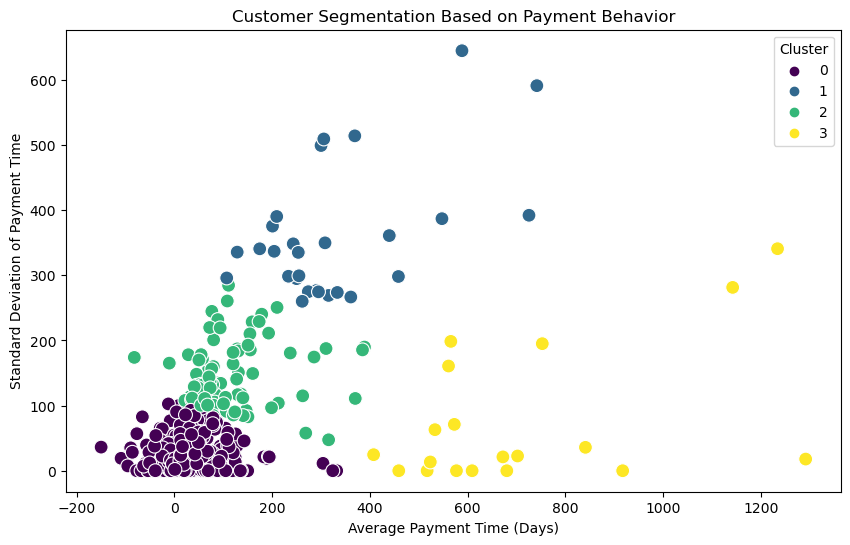

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_payment_stats, x='avg_payment_time', y='std_payment_time', hue='cluster', palette='viridis', s=100)
plt.title('Customer Segmentation Based on Payment Behavior')
plt.xlabel('Average Payment Time (Days)')
plt.ylabel('Standard Deviation of Payment Time')
plt.legend(title='Cluster')
plt.show()


* Interpret the Clusters
After clustering, analyze the characteristics of each cluster to understand the different types of payment behaviors:

Cluster 0: Customers with consistently on-time payments.
Cluster 1: Customers with slight delays but low variability.
Cluster 2: Customers with frequent and consistent delays.
Cluster 3: Customers with highly variable payment times, indicating inconsistency.

* Actionable Insights
Based on the clusters:

Engage with consistently late payers (e.g., Cluster 2) for better terms or reminders.
Reward consistently on-time payers (e.g., Cluster 0) with discounts or incentives.
Investigate inconsistent payers (e.g., Cluster 3) to understand the causes and address any issues.



### Visualize the distribution of invoice values

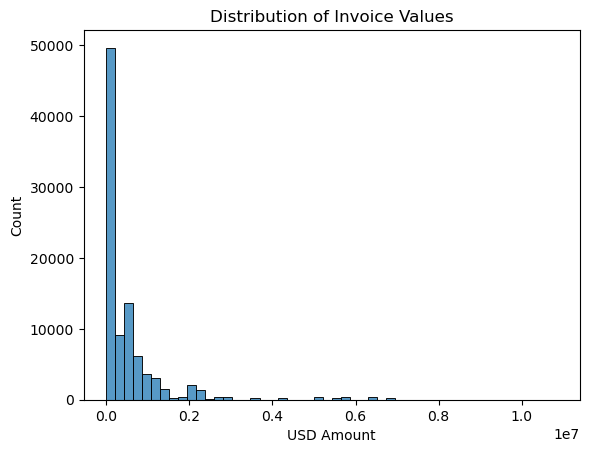

In [51]:
sns.histplot(received_payments['USD Amount'], bins=50)
plt.title('Distribution of Invoice Values')
plt.show()

## 1. Exploratory Data Analysis (EDA) Visualizations

### Distribution of Invoice Values
- Visualize the distribution of invoice values to understand the data spread and identify any outliers.

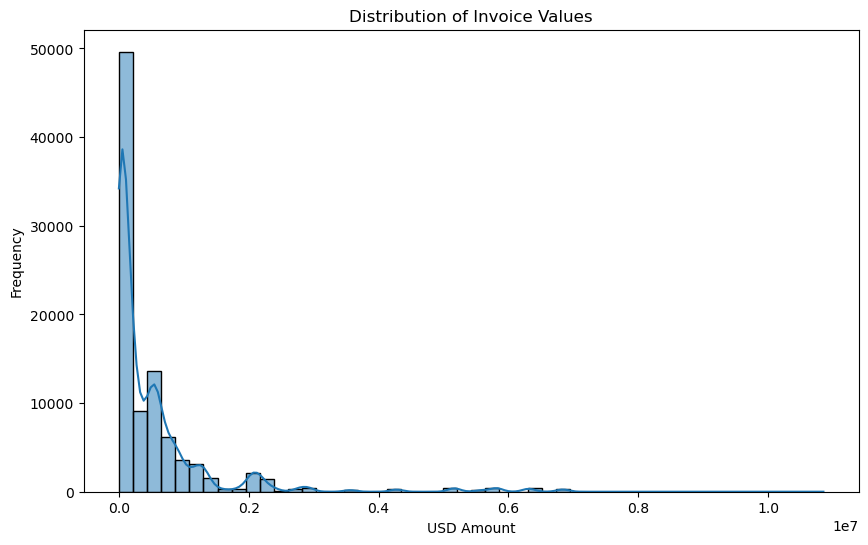

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(received_payments['USD Amount'], bins=50, kde=True)
plt.title('Distribution of Invoice Values')
plt.xlabel('USD Amount')
plt.ylabel('Frequency')
plt.show()


### Payment Term Distribution
-Display the distribution of payment terms in days.

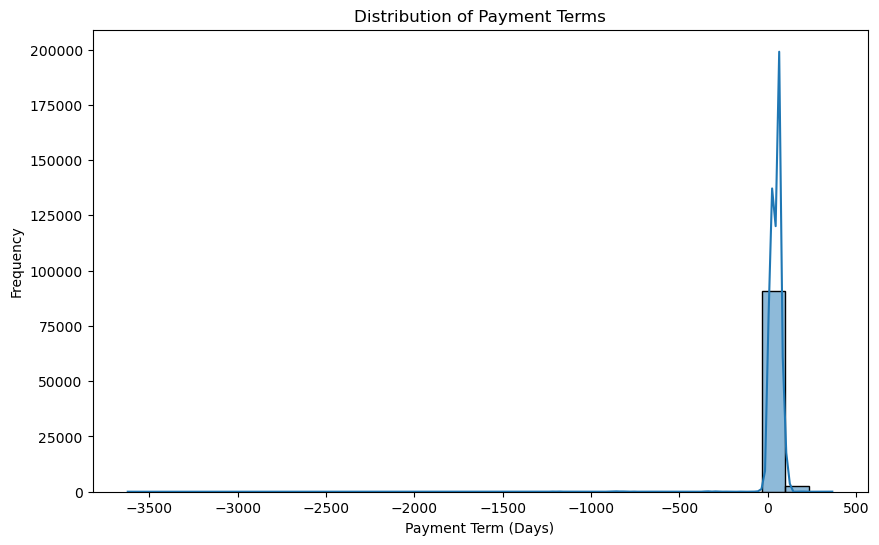

In [58]:
received_payments['payment_term_days'] = (received_payments['DUE_DATE'] - received_payments['INVOICE_CREATION_DATE']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(received_payments['payment_term_days'], bins=30, kde=True)
plt.title('Distribution of Payment Terms')
plt.xlabel('Payment Term (Days)')
plt.ylabel('Frequency')
plt.show()


### Late Payment Rate by Invoice Value
- Show the rate of late payments across different invoice value ranges.

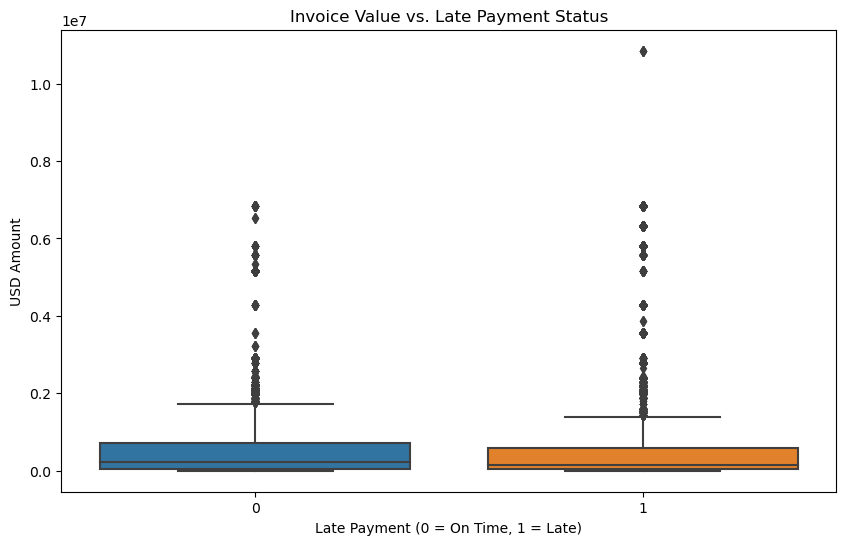

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LATE_PAYMENT', y='USD Amount', data=received_payments)
plt.title('Invoice Value vs. Late Payment Status')
plt.xlabel('Late Payment (0 = On Time, 1 = Late)')
plt.ylabel('USD Amount')
plt.show()


## Customer Segmentation

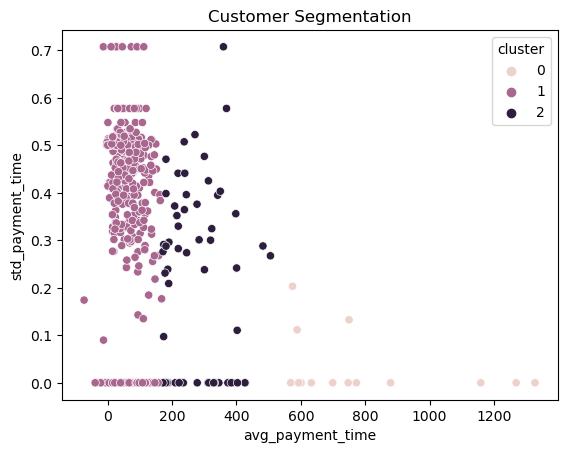

In [65]:
# Calculate average and standard deviation of payment times for each customer
customer_payment_stats = received_payments.groupby('CUSTOMER_NAME').agg({
    'RECEIPT_DATE': lambda x: (x - received_payments['INVOICE_CREATION_DATE']).dt.days.mean(),
    'LATE_PAYMENT': 'std'
}).rename(columns={'RECEIPT_DATE': 'avg_payment_time', 'LATE_PAYMENT': 'std_payment_time'})

# Drop rows with NaN values (customers without variance in payment times)
customer_payment_stats.dropna(inplace=True)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
customer_payment_stats['cluster'] = kmeans.fit_predict(customer_payment_stats)

# Plot the clusters
sns.scatterplot(data=customer_payment_stats, x='avg_payment_time', y='std_payment_time', hue='cluster')
plt.title('Customer Segmentation')
plt.show()


### 2. Customer Segmentation Visualization

-Visualize the customer clusters based on payment behavior.

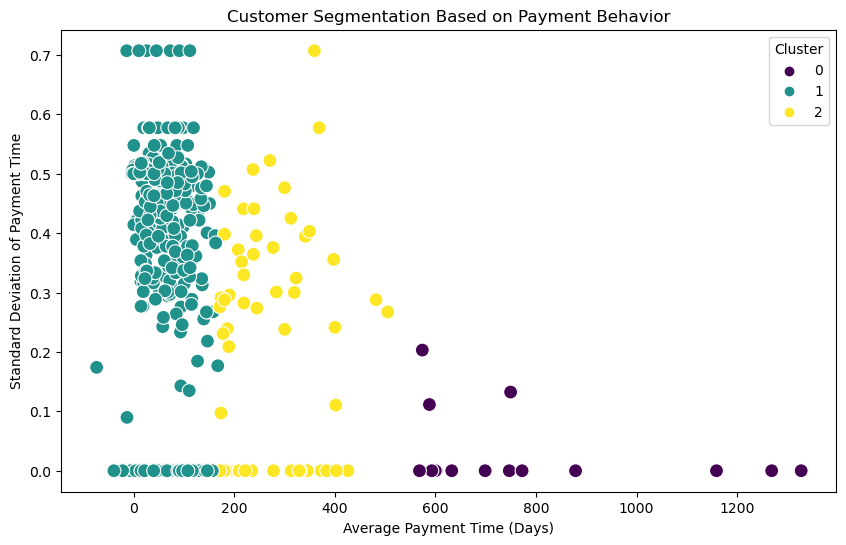

In [103]:
# Assuming customer_payment_stats with cluster labels already computed
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_payment_stats, x='avg_payment_time', y='std_payment_time', hue='cluster', palette='viridis', s=100)
plt.title('Customer Segmentation Based on Payment Behavior')
plt.xlabel('Average Payment Time (Days)')
plt.ylabel('Standard Deviation of Payment Time')
plt.legend(title='Cluster')
plt.show()


In [104]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      9532
           1       0.89      0.93      0.91     18650

    accuracy                           0.87     28182
   macro avg       0.86      0.85      0.86     28182
weighted avg       0.87      0.87      0.87     28182



## MODEL BUILDING

In [77]:
# Prepare features and target variable for the model
features = received_payments[['USD Amount', 'DUE_DATE', 'INVOICE_CREATION_DATE']]
features['payment_term_days'] = (received_payments['DUE_DATE'] - received_payments['INVOICE_CREATION_DATE']).dt.days


C:\Users\MYNUDDIN\AppData\Local\Temp\ipykernel_7676\3602919347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['payment_term_days'] = (received_payments['DUE_DATE'] - received_payments['INVOICE_CREATION_DATE']).dt.days


In [78]:
features = features.drop(columns=['DUE_DATE', 'INVOICE_CREATION_DATE'])

In [79]:
# Prepare the target variable
target = received_payments['LATE_PAYMENT']

In [80]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)


In [81]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [82]:
# Predictions
y_pred = model.predict(X_test)

In [83]:
# Model Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      9532
           1       0.89      0.93      0.91     18650

    accuracy                           0.87     28182
   macro avg       0.86      0.85      0.86     28182
weighted avg       0.87      0.87      0.87     28182

[[ 7355  2177]
 [ 1395 17255]]


## Model Performance Metrics

-- Display the models performance using a confusion matrix and classification report.

### a. Confusion Matrix

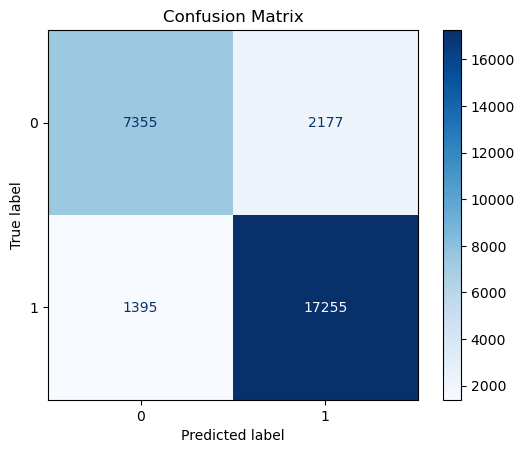

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


### b. Classification Report

In [90]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      9532
           1       0.89      0.93      0.91     18650

    accuracy                           0.87     28182
   macro avg       0.86      0.85      0.86     28182
weighted avg       0.87      0.87      0.87     28182



##  Feature Importance Plot

- Highlight the importance of different features in the model.

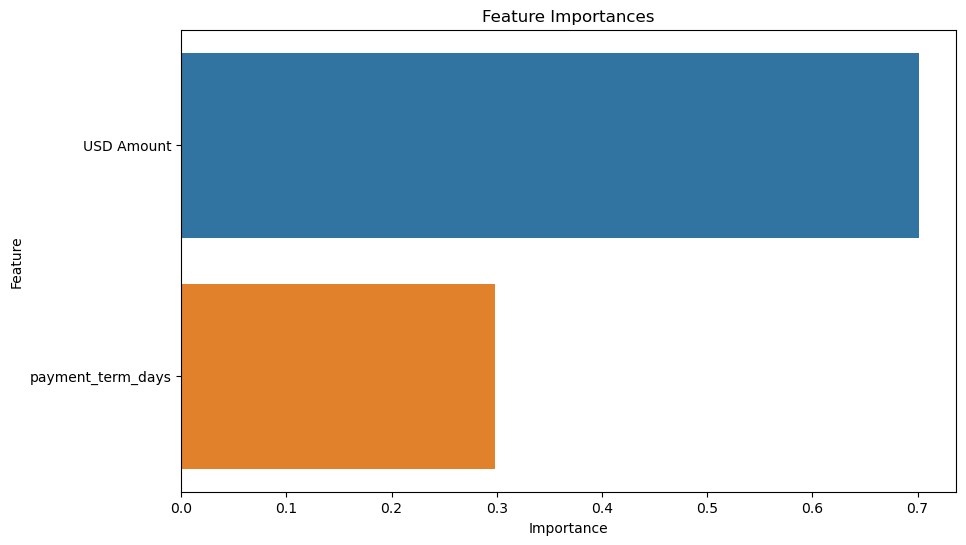

In [97]:
# Get feature importances from the model
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### Probability of Late Payment by Customer
-Visualize the average probability of late payment for each customer.



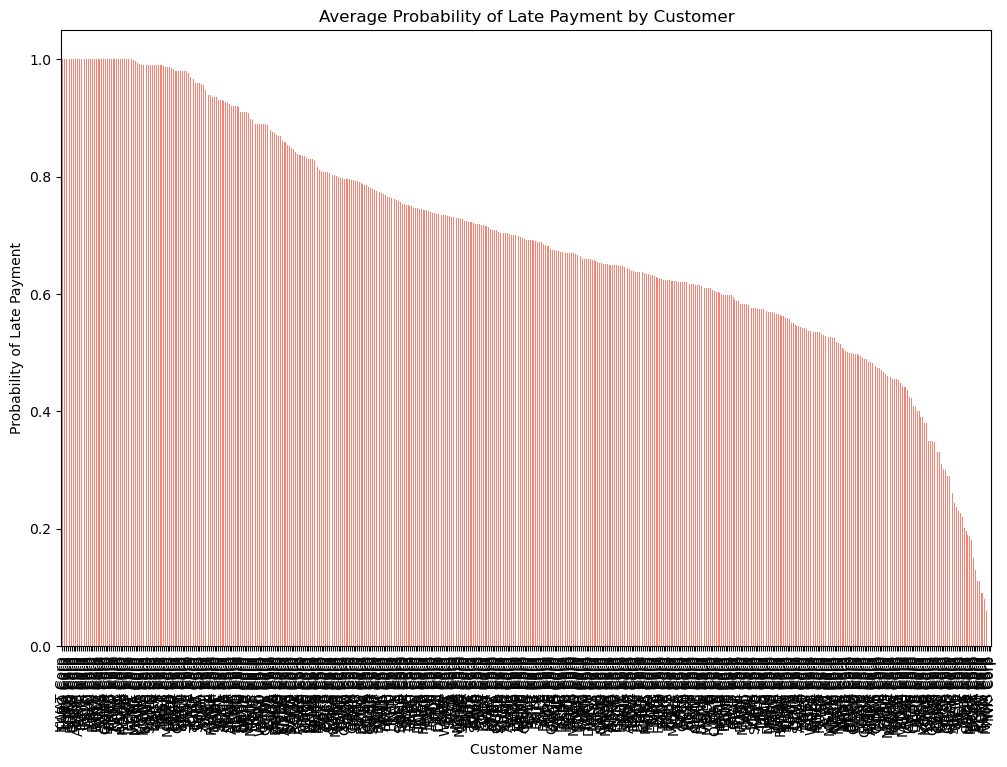

In [95]:
# Sort customers by the probability of late payment
sorted_probs = customer_late_payment_prob.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sorted_probs.plot(kind='bar', color='salmon')
plt.title('Average Probability of Late Payment by Customer')
plt.xlabel('Customer Name')
plt.ylabel('Probability of Late Payment')
plt.xticks(rotation=90)
plt.show()


## Application on open invoices data

In [105]:
### Convert 'USD Amount' to string (if it isn't already)
open_invoices_not_due['USD Amount'] = open_invoices_not_due['USD Amount'].astype(str)

In [106]:
### Remove commas and convert to float
open_invoices_not_due['USD Amount'] = open_invoices_not_due['USD Amount'].str.replace(',', '').astype(float)

In [107]:
### Calculate payment term in days
open_invoices_not_due['payment_term_days'] = (open_invoices_not_due['Due Date'] - open_invoices_not_due['Transaction Date']).dt.days

In [110]:
# Predict late payment probabilities
# Ensure that only numerical features are passed to the model
numerical_features = open_invoices_not_due[['USD Amount', 'payment_term_days']]
open_invoices_not_due['late_payment_prob'] = model.predict_proba(numerical_features)[:, 1]

In [111]:
# Aggregate results at customer level
customer_late_payment_prob = open_invoices_not_due.groupby('Customer_Name')['late_payment_prob'].mean()

In [112]:
# Display results
print(customer_late_payment_prob)

Customer_Name
2H F Corp    0.685556
3D D Corp    0.547721
6TH  Corp    0.765000
ABDU Corp    0.695030
ABEE Corp    0.575000
               ...   
ZAIN Corp    0.717944
ZALL Corp    0.841939
ZALZ Corp    0.622000
ZINA Corp    0.880000
ZUHA Corp    0.704303
Name: late_payment_prob, Length: 495, dtype: float64


## 5 Display out put visualization

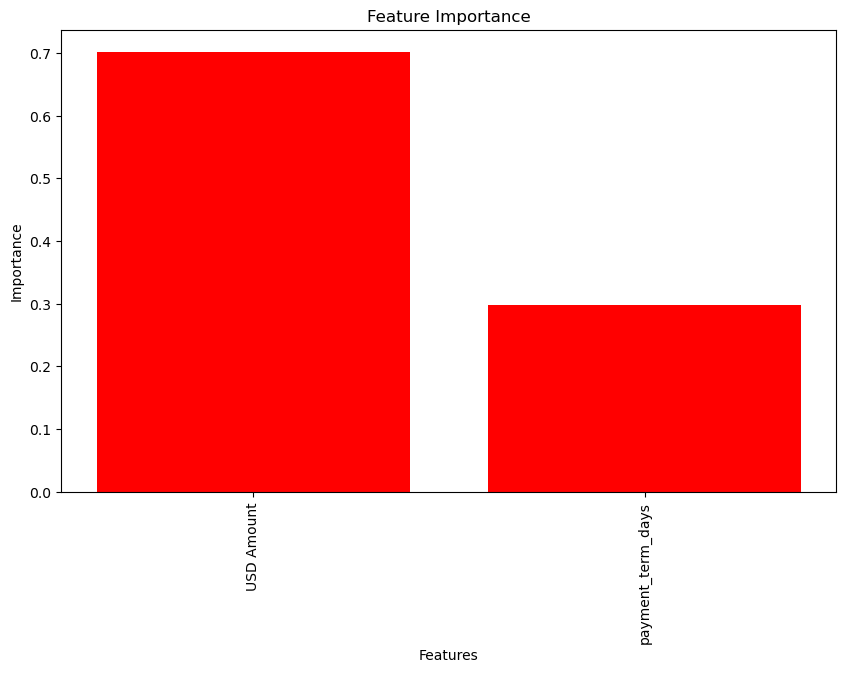

In [130]:
# Feature Importance Plot
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


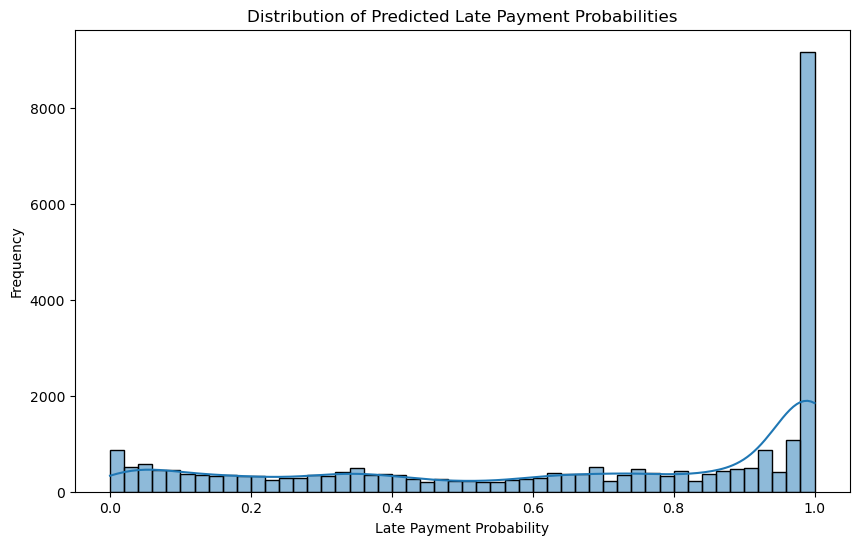

In [144]:
plt.figure(figsize=(10, 6))
sns.histplot(open_invoices_not_due['late_payment_prob'], bins=50, kde=True)
plt.title('Distribution of Predicted Late Payment Probabilities')
plt.xlabel('Late Payment Probability')
plt.ylabel('Frequency')
plt.show()


In [136]:
# Summary Table of Customer Segments
segment_summary = customer_payment_stats.groupby('cluster').agg({
    'avg_payment_time': ['mean', 'std'],
    'std_payment_time': ['mean', 'std'],
    'cluster': 'size'
}).reset_index()
segment_summary.columns = ['Cluster', 'Avg Payment Time Mean', 'Avg Payment Time Std', 'Std Payment Time Mean', 'Std Payment Time Std', 'Number of Customers']
print(segment_summary)

   Cluster  Avg Payment Time Mean  Avg Payment Time Std  \
0        0              21.252266             47.298697   
1        1             327.553718            158.651956   
2        2             116.534493             86.922998   
3        3             713.497466            259.343405   

   Std Payment Time Mean  Std Payment Time Std  Number of Customers  
0              24.823991             22.839920                  560  
1             360.460801            101.974403                   28  
2             148.318975             50.500823                   83  
3              76.130082            105.659063                   19  


In [138]:
open_invoice_data.columns

Index(['AS_OF_DATE', 'Customer Type', 'Customer_Name', 'Customer Account No',
       'Transaction Number', 'Transaction Date', 'Payment Term', 'Due Date',
       'Transaction Currency', 'Local Amount', 'Transaction Class', 'AGE',
       'USD Amount', 'INV_CREATION_DATE'],
      dtype='object')

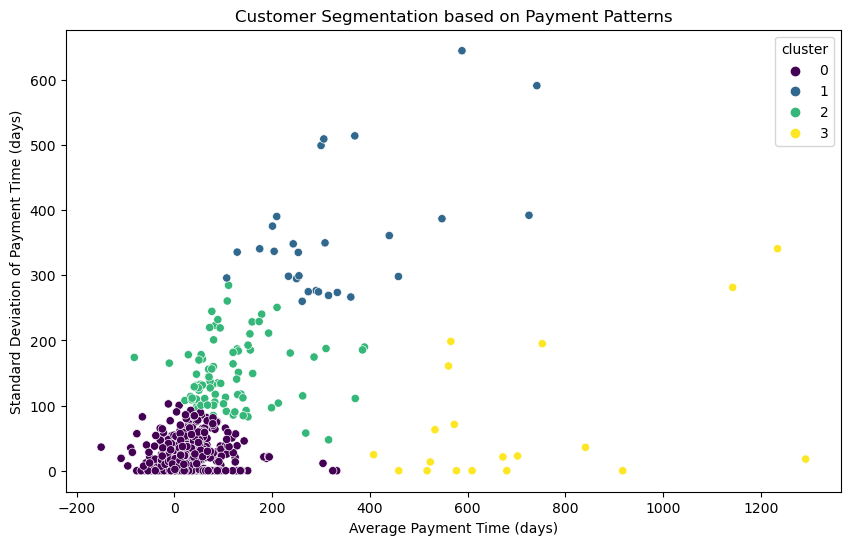

In [159]:
# Customer Segmentation Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_payment_time', y='std_payment_time', hue='cluster', data=customer_payment_stats, palette='viridis')
plt.title('Customer Segmentation based on Payment Patterns')
plt.xlabel('Average Payment Time (days)')
plt.ylabel('Standard Deviation of Payment Time (days)')
plt.show()


* Interpret the Clusters
After clustering, analyze the characteristics of each cluster to understand the different types of payment behaviors:

Cluster 0: Customers with consistently on-time payments.
Cluster 1: Customers with slight delays but low variability.
Cluster 2: Customers with frequent and consistent delays.
Cluster 3: Customers with highly variable payment times, indicating inconsistency.

* Actionable Insights
Based on the clusters:

Engage with consistently late payers (e.g., Cluster 2) for better terms or reminders.
Reward consistently on-time payers (e.g., Cluster 0) with discounts or incentives.
Investigate inconsistent payers (e.g., Cluster 3) to understand the causes and address any issues.

